#                                                 Stroke Predictor
### COMP 377 - AI for Software Developers (SEC001)
### Group 5
#### Jin Jong Yoo
#### Roberto Daniel Aguinaldo
#### Baris Berber
#### Jiaying Song

### Introduction 

The second leading cause of death globally are strokes according to the World Health Organization (WHO). Approximately 11% of total deaths are attributed to strokes. 

We would like to analyze risk characteristics for stroke and predict the likelihood of getting a stroke

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import preprocessing 
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os

#read the file
df = pd.read_csv("C:/Users/cheto/Desktop/Centennial/AI for Software Developers/Group Project/AIProject/stroke_data.csv")

### Drop irrelevant id column

In [2]:
df.drop("id", axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Check target value proportion

0    4861
1     249
Name: stroke, dtype: int64


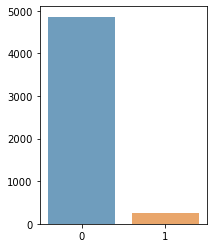

In [3]:
strokes = df.stroke.value_counts()
print(strokes)
plt.figure(figsize=[3,4])
sns.barplot(x=strokes.index, y=strokes.values, alpha = 0.7)
plt.show()

### Balance the dataset

In [4]:
dataNoStrok = df[df.stroke != 1]
dataYesStroke = df[df.stroke != 0]
dataNoStrok = dataNoStrok.sample(300)
df = pd.concat([dataNoStrok,dataYesStroke],axis=0)

0    300
1    249
Name: stroke, dtype: int64


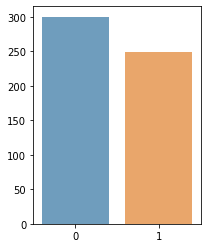

In [5]:
strokes = df.stroke.value_counts()
print(strokes)
plt.figure(figsize=[3,4])
sns.barplot(x=strokes.index, y=strokes.values, alpha = 0.7)
plt.show()

In [6]:
import pandas_profiling as pp
pp.ProfileReport(df)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

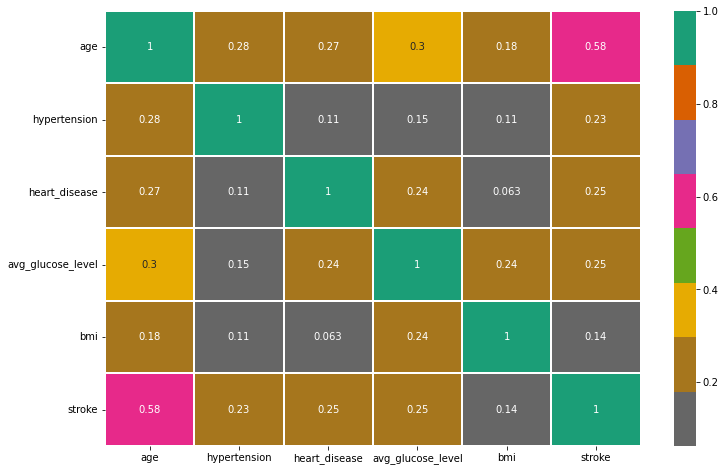

In [7]:
plt.figure(figsize=(12,8)) 
sns.heatmap(df.corr(), annot=True, cmap='Dark2_r', linewidths = 2)
plt.show()

### Getting rid of outliers

In [8]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers

In [9]:
df.loc[detect_outliers(df,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke'])]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
193,Male,68.0,1,1,Yes,Private,Rural,271.74,31.1,smokes,1
220,Male,81.0,1,1,Yes,Private,Urban,250.89,28.1,smokes,1
243,Female,68.0,1,1,Yes,Private,Urban,247.51,40.5,formerly smoked,1


In [10]:
# drop outliers
df = df.drop(detect_outliers(df,['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']),axis = 0).reset_index(drop = True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,74.0,0,0,Yes,Govt_job,Urban,251.99,25.5,never smoked,0
1,Female,28.0,0,0,No,Private,Rural,96.86,29.0,Unknown,0
2,Male,2.0,0,0,No,children,Urban,80.98,19.9,Unknown,0
3,Female,51.0,0,0,Yes,Private,Rural,81.73,27.4,never smoked,0
4,Female,47.0,0,0,Yes,Private,Urban,157.01,26.1,smokes,0


In [11]:
print("Mean of BMI value for Females: ", np.mean(df[df['gender'] == 'Female']['bmi']))
print("Mean of BMI value for Males: ", np.mean(df[df['gender'] == 'Male']['bmi']))
print("Mean of BMI value for Others: ", np.mean(df['bmi']))

Mean of BMI value for Females:  29.111149825783947
Mean of BMI value for Males:  29.471770334928227
Mean of BMI value for Others:  29.263104838709662


In [12]:
#fill bmi missing values with a zero
df['bmi'] = df['bmi'].fillna(0)

In [13]:
len(df.index)

546

In [32]:
#28.594683544303823
#29.035926055109936
#28.854652338161664

In [14]:
#use the filled zero values and fill in the average
for i in range(0,545):
    if(df['bmi'][i] == 0):
        if(df['gender'][i] == 'Male'):
            df['bmi'][i] = 28.594683544303823
        elif(df['gender'][i] == 'Female'):
            df['bmi'][i] = 29.035926055109936
        else:
            df['bmi'][i] = 28.854652338161664

In [15]:
#check missing values
df[df['bmi'].isnull()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### Convert string values to numeric values

In [16]:
print("Unique Values for Gender", df['gender'].unique())
print("Unique Values for ever_married",df['ever_married'].unique())
print("Unique Values for work_type", df['work_type'].unique())
print("Unique Values for Residence_type", df['Residence_type'].unique())
print("Unique Values for smoking_status", df['smoking_status'].unique())

Unique Values for Gender ['Female' 'Male']
Unique Values for ever_married ['Yes' 'No']
Unique Values for work_type ['Govt_job' 'Private' 'children' 'Self-employed' 'Never_worked']
Unique Values for Residence_type ['Urban' 'Rural']
Unique Values for smoking_status ['never smoked' 'Unknown' 'smokes' 'formerly smoked']


In [17]:
gender_mapping = {'Female': 0, 'Male': 1, 'Other': 2}
df['gender'] = df['gender'].map(gender_mapping)

ever_married_mapping = {'No': 0, 'Yes': 1}
df['ever_married'] = df['ever_married'].map(ever_married_mapping)

work_type_mapping = {'Self-employed': 0, 'Private': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}
df['work_type'] = df['work_type'].map(work_type_mapping)

Residence_type_mapping = {'Rural': 0, 'Urban': 1}
df['Residence_type'] = df['Residence_type'].map(Residence_type_mapping)

smoking_status_mapping = {'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3}
df['smoking_status'] = df['smoking_status'].map(smoking_status_mapping)

### Model Building

In [18]:
features = ['age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'gender',
 'work_type',
 'smoking_status']

label = ['stroke']

X = df[features]
y = df[label]

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3) 

print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 546
Total # of sample in train dataset: 436
Total # of sample in test dataset: 110


In [20]:
#standardization
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegression
logre = LogisticRegression()
logre.fit(X_train,y_train)

LogisticRegression()

In [22]:
from sklearn.metrics import accuracy_score
y_pred = logre.predict(X_test)
print("Model Accuracy:")
print(accuracy_score(y_test,y_pred))

Model Accuracy:
0.7727272727272727


In [23]:
t_gender = 1
t_age = 67
t_hypertension = 0
t_heart_disease = 1
t_ever_married = 1
t_work_type = 1
t_Residence_type = 1
t_avg_glucose_level = 228.69
t_bmi = 36.6
t_smoking_status = 2

test_set = [[t_age,t_hypertension,t_heart_disease,
                             t_ever_married,t_Residence_type,
                             t_avg_glucose_level,t_bmi,t_gender,t_work_type,
                            t_smoking_status]]

test = sc.transform(test_set)

prediction = logre.predict(test)

prediction_prob = logre.predict_proba(test)

print(prediction[0])

1


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
print("97% of stroke predicted correct")
print("No prediction of absence of stroke was predicted correct")

              precision    recall  f1-score   support

           0       0.80      0.78      0.79        60
           1       0.75      0.76      0.75        50

    accuracy                           0.77       110
   macro avg       0.77      0.77      0.77       110
weighted avg       0.77      0.77      0.77       110

97% of stroke predicted correct
No prediction of absence of stroke was predicted correct


[[47 13]
 [12 38]]
976 true positives, 0 true negatives, 0 false positive, and 31 false negatives


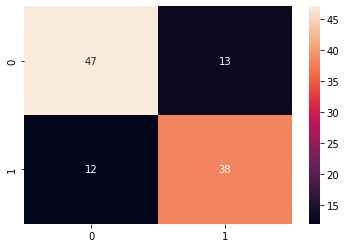

In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
print("976 true positives, 0 true negatives, 0 false positive, and 31 false negatives")

In [26]:
#Model Intercept
print(logre.intercept_)

[-0.54279797]


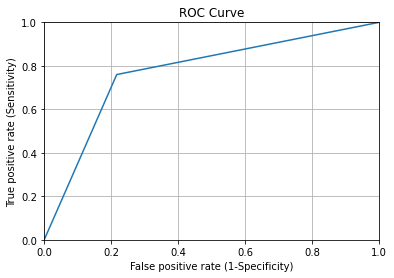

In [27]:
#ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)